In [84]:
import numpy as np
import cv2
import math
from glob import *
from matplotlib import pyplot as plt
from matplotlib import patches
from scipy.ndimage import filters

### some tools

In [97]:
### print imgs in array
def print_all(imgs):
    for i in imgs:
        plt.imshow(i)
        plt.show()



## Data Sturctures

In [191]:
# point is just a pair (y,x)

class KeyPoint():
    def __init__(self, point, angle=-1, response=0, octave=0):
        self.point = point         # coordinate (y,x)
        self.angle = angle
        self.response = response
        self.octave = octave

# descriptor is a patch of (8x8) pixels (array)
        

## read images

In [4]:
img_dir = "../data/grail"
img_ext = [".jpg", ".JPG"]
filenames = [f for f in glob(img_dir + "/*" + img_ext[0])]
filenames.sort()

if not glob(img_dir):
   print("dir not found")

IMGS = []
for n in filenames:
    IMGS.append(cv2.imread(n))

# print_all(IMGS)

## Feture detection

### Harris corner response

In [7]:
# return the Harris response for each pixel in the gray-scale img
def harris_response(src, sigma=1.5, k=0.04, ksize=3, sobel=True):
    Ix = np.zeros(src.shape)
    Iy = np.zeros(src.shape)
    
    if sobel:
        Ix = cv2.Sobel(src, -1, 1, 0, ksize)
        Iy = cv2.Sobel(src, -1, 0, 1, ksize)
    else:
        filters.gaussian_filter(src, (sigma,sigma), (0,1), Ix)
        filters.gaussian_filter(src, (sigma,sigma), (1,0), Iy)
    
    Sxx = filters.gaussian_filter(Ix**2, sigma)
    Sxy = filters.gaussian_filter(Ix*Iy, sigma)
    Syy = filters.gaussian_filter(Iy**2, sigma)

    det = Sxx * Syy - Sxy**2
    trace = Sxx + Syy
    
    # harmonic means
    return det/(trace+1e-8)
   

''' test '''
# im = cv2.cvtColor(imgs[0], cv2.COLOR_BGR2GRAY)
# harris_response(im)

' test '

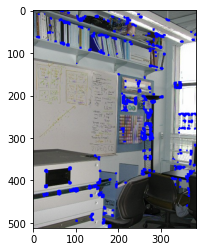

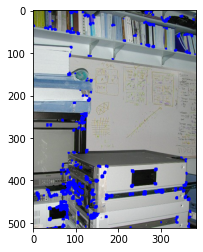

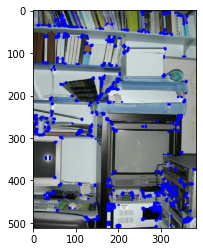

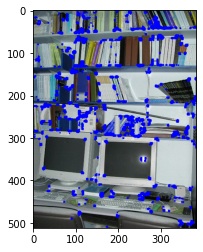

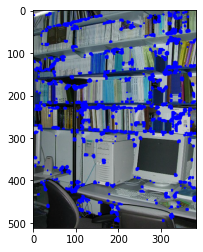

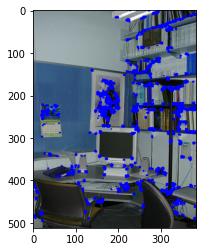

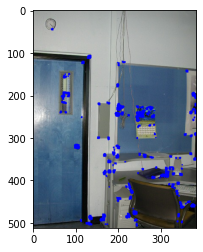

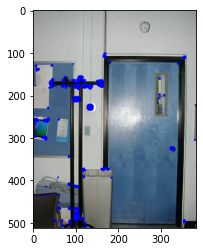

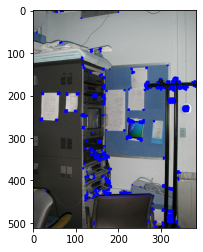

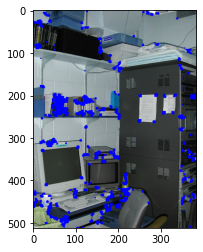

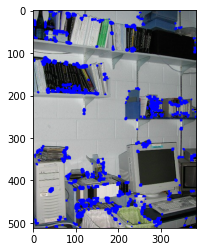

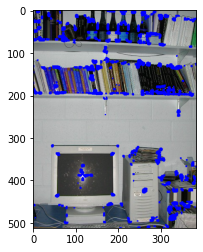

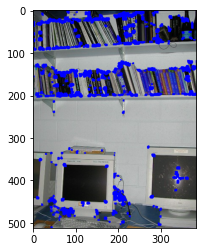

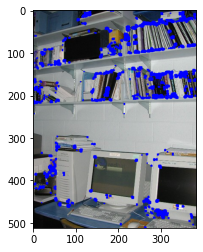

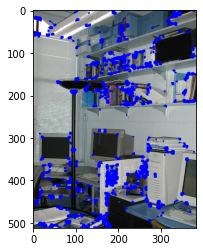

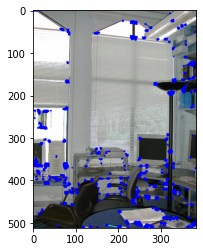

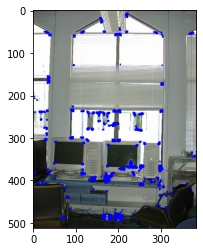

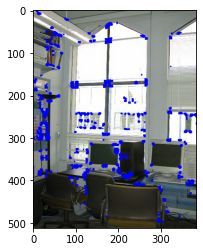

In [167]:
'''test'''
# get all imgs' harris response
imgs = [i.copy() for i in IMGS]
for img in imgs:
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = harris_response(gray,sobel=False)
#     dst = cv2.cornerHarris(gray,2,3,0.04)
    dst = cv2.dilate(dst, None)
    img[dst>0.1*dst.max()] = [0, 0, 255]
    
print_all(imgs)

### Non-maximum Suppression

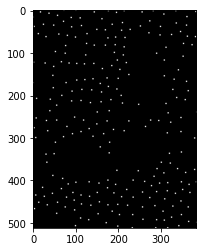

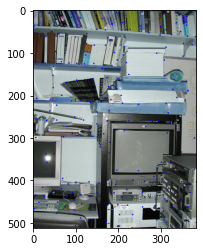

In [212]:
# return the mapping of maximum n points
def NMS(src, n=500, r=-1, circle=True):
    if r < 0:
        r = src.shape[0]//10
    
    thres = src.max() * 0.01
#     print(src.max())
    
    keypoints = []
    while len(keypoints) < n and r > 0:
        # init keypoint mask & previous selected points
        kmask = src.copy()
        for kp in keypoints:
            y,x = kp
            cv2.circle(kmask, (x,y), r, 0, -1)
            
        while True:
            y,x = np.unravel_index(kmask.argmax(axis=None), kmask.shape)
            maxn = kmask[(y,x)]
            # mask circle if the point value > threshold
            if maxn > thres:
                cv2.circle(kmask, (x,y), r, 0, -1)
            else:
                break
                
            keypoints.append((y,x))
#             print(len(keypoints),":",y,x)

#         print("---\n* r =",r)
#         kmask[kmask>0] = 1
#         plt.imshow(kmask, cmap='gray')
#         plt.show()
        r = r-1
    
    # mapping to img
    fmap = np.zeros(src.shape)
    for kp in keypoints:
        fmap[kp] = 1
         
    return fmap
    
'''test'''
im = IMGS[2].copy()
gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = harris_response(gray,sobel=False)
dst = NMS(dst, n=250)
dst = cv2.dilate(dst, None)
im[dst==1] = [0,0,255]
plt.imshow(dst, cmap='gray')
plt.show()
plt.imshow(im)
plt.show()

228.11157558115414


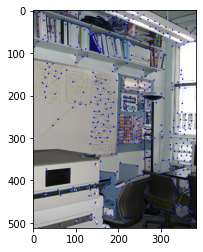

268.06089890522173


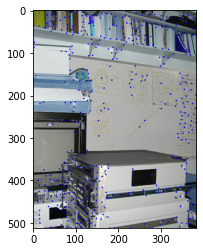

278.8860468443816


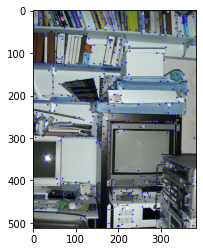

234.96398399151727


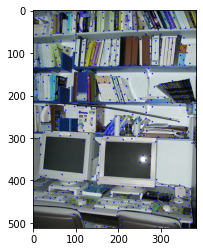

157.40099757950046


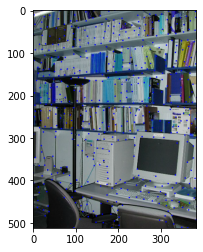

143.20830272380763


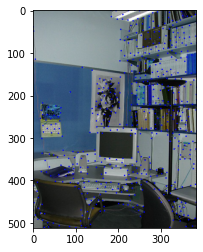

124.37326480480726


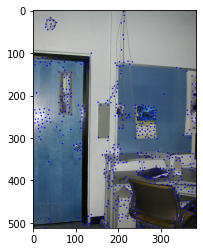

234.5944548478351


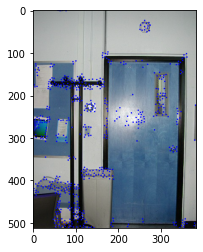

232.40268782192854


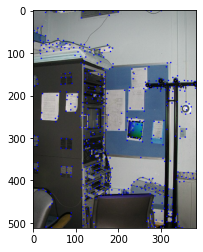

206.6089163635082


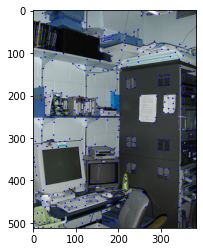

214.001594510047


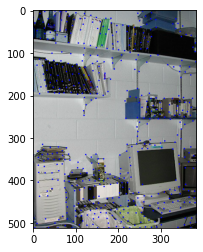

180.27217880743126


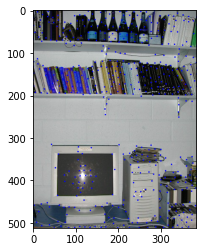

184.003956401048


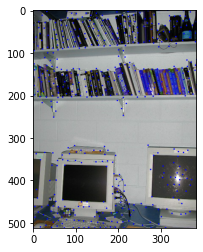

235.75230837852698


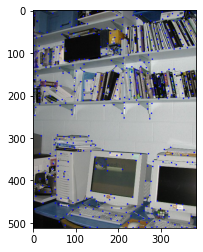

173.04208525082794


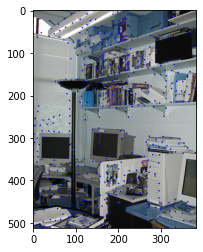

178.44182087011683


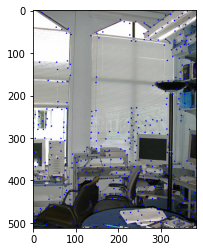

257.15335562152063


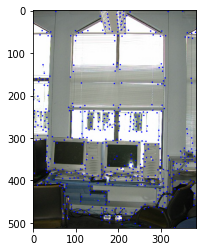

218.0478595045366


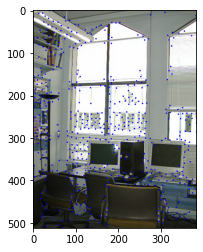

In [165]:
imgs = [i.copy() for i in IMGS]
for img in imgs:
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = harris_response(gray,sobel=False)
    dst = NMS(dst)
    dst = cv2.dilate(dst, None)
    img[dst==1] = [0,0,255]
    plt.imshow(img)
    plt.show()
    
# print_all(imgs)

In [222]:
# convert src to float grayscale image, return a feature point map
def feature_detection(src):
    gray = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    response = harris_response(gray, sobel=False)
    fmap = NMS(response)
    
    return fmap

# '''test'''
# imgs = [i.copy() for i in IMGS]
# for im in imgs:
#     fmap = feature_detection(im)
#     fmap = cv2.dilate(fmap,None)
#     plt.imshow(fmap, cmap='gray')
#     plt.show()

## Feature Description

### orientation assignment

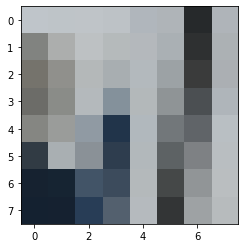

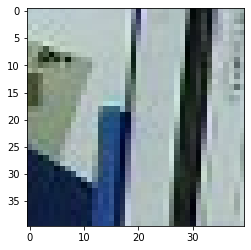

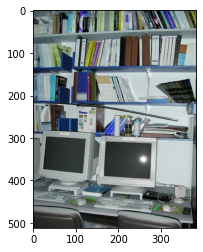

(40, 40, 3)

In [174]:
# extract patch from src (rectangle)
def extract_patch(src, start, end):
    x1 = start[0] if start[0] > 0 else 0
    y1 = start[1] if start[1] > 0 else 0
    x2 = end[0] if end[0] < src.shape[1] else src.shape[1]
    y2 = end[1] if end[1] < src.shape[0] else src.shape[0]
    patch = src[y1:y2, x1:x2].copy()
    return patch

# sample patch after gaussian smoothing
def sample_patch(src, sigma=1.0, normalize=False):
    # only 40x40 src are allowed
    if src.shape[0] != 40 or src.shape[1] != 40:
        raise Exception("patch sampling")
    blurred = filters.gaussian_filter(src, sigma)
    sampled = cv2.resize(blurred, (8,8))
    norm = (sampled-np.mean(sampled))/np.std(sampled)
    if normalize:
        return norm
    else: 
        return sampled

# ''''''
src = IMGS[3].copy()
x, y, r = (100, 100, 20) # center
patch40 = extract_patch(src, (x-r,y-r), (x+r,y+r))
patch8 = sample_patch(patch40)

plt.imshow(patch8)
plt.show()
plt.imshow(patch40)
plt.show()
plt.imshow(src)
plt.show()
patch40.shape
    

75 75


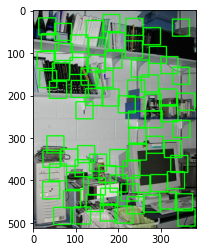

test done


In [233]:


# returns a set of keypoints & descriptor
def feature_description(src, fmap):
    
    # extract features from fmap
    features = []
    for i,f in enumerate(fmap.flatten()):
        if f != 0:
            y,x = np.unravel_index(i, fmap.shape)
            features.append((y,x))
    

    Dx = cv2.Sobel(src, cv2.CV_64F, 1, 0, ksize=5)
    Dy = cv2.Sobel(src, cv2.CV_64F, 0, 1, ksize=5)
    
    keypoints = []
    descriptors = []
    for fp in features:
        y,x = fp
        r = 20
        # orientation assignment
#         rmat = cv2.getRotationMatrix2D((y,x), math.atan2(Dy[(y,x)], Dx[(y,x)]), scale=1.0)
#         rimg = cv2.warpAffine(src, rmat, (src.shape[1], src.shape[0]))
    
#         u = filters.gaussian_filter(src, sigma)
#         plt.imshow(rimg)
#         plt.show()
#         plt.imshow(Dx,cmap='gray')
#         plt.show()
#         plt.imshow(Dy,cmap='gray')
#         plt.show()
    
        # extract patch from src
        # eliminate marginal
        if x-r < 0 or y-r < 0 or x+r > src.shape[1] or y+r > src.shape[0]:
            continue
            
        patch40 = extract_patch(src, (x-r,y-r), (x+r,y+r))
        patch8 = sample_patch(patch40).flatten()
#         print(patch8)

        keypoints.append(KeyPoint(fp))
        descriptors.append(patch8)
        
    return keypoints, descriptors
        
    
'''test'''
im = IMGS[10].copy()
gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
fmap = harris_response(gray)
fmap = NMS(fmap, n=100)
kp, des = feature_description(gray, fmap)
print(len(kp), len(des))

# draw rectangle
for k in kp:
    y,x = k.point
    cv2.rectangle(im, (x-20,y-20), (x+20,y+20), (0,255,0), 2)
    
plt.imshow(im)
plt.show()
print("test done")

## The Main MSOP 

In [251]:
##### multi scale oriented patch
##### return a keypoint pyramid & a descriptor pyramid of one image,
##### img = original RGB image
def MSOP(img, scale=4):
    kpPyr = []
    desPyr = []
    src = img
    for i in range(scale):
        fmap = feature_detection(src)
        kp, des = feature_description(src,fmap)
        kpPyr.append(kp)
        desPyr.append(des)
        src = cv2.pyrDown(src)
        
    return kpPyr, desPyr
        
'''test'''
from time import time
imgs = [i.copy() for i in IMGS]

start_time = time()

KP = []
DES = []
for im in imgs:
    kpPyr, desPyr = MSOP(im)
    KP.append(kpPyr)
    DES.append(desPyr)
    
end_time = time()

print("elapsed: {:.2f}(s)".format(end_time-start_time))    
print("test ended")

elapsed: 15.25(s)
test ended
